# 05 Using a drive cycle

PyBaMM provides a number of example drive cycles that define the instantaneous current which can be read in from csv files. So we first change our current directory to the PyBaMM root directory in order to read it in.

In [1]:
try:
    import liionpack as lp
except ModuleNotFoundError:
    !pip install -q git+https://github.com/pybamm-team/liionpack.git@main
    import liionpack as lp
import pybamm
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

os.chdir(pybamm.__path__[0] + "/..")

C:\Users\tgtra\anaconda3\envs\liionpack\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-20 12:56:13,672	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
# import drive cycle from file
drive_cycle = pd.read_csv(
    "pybamm/input/drive_cycles/US06.csv", comment="#", header=None
).to_numpy()

Let's have a look at the drive cycle. The first column is the time stamp and the second is the current.

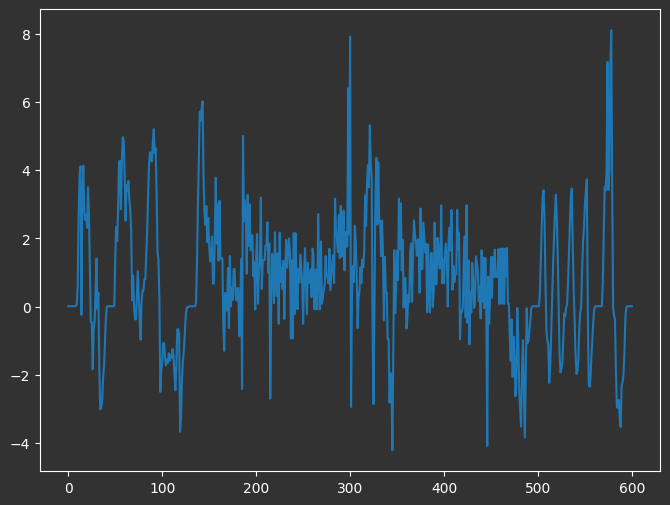

In [4]:
with plt.rc_context(lp.lp_context()):
    plt.figure(figsize=(8, 6))
    plt.plot(drive_cycle[:, 0], drive_cycle[:, 1])

We can load an experiment using the drive cycle and give it a dictionary key and an operating condition to run it. N.B this is a new feature for PyBaMM and syntax may change so please consult the documentation and make sure you have the latest version of PyBaMM.

In [5]:
experiment = pybamm.Experiment(
    [pybamm.step.current(drive_cycle)],
    period="1 second",
)

Set up our pack using our chemistry of interest.

In [6]:
netlist = lp.setup_circuit(Np=4, Ns=1, Rb=1e-4, Rc=1e-3, Ri=5e-2, V=4.0, I=1.0)

In [7]:
# Heat transfer coefficients
htc = np.ones(4) * 10
# PyBaMM parameters
parameter_values = pybamm.ParameterValues("Chen2020")

In [8]:
# Solve pack
output_d = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    initial_soc=0.75,
)

Stepping simulation: 100%|██████████████████████████████████████████████████████████| 601/601 [00:05<00:00, 105.96it/s]


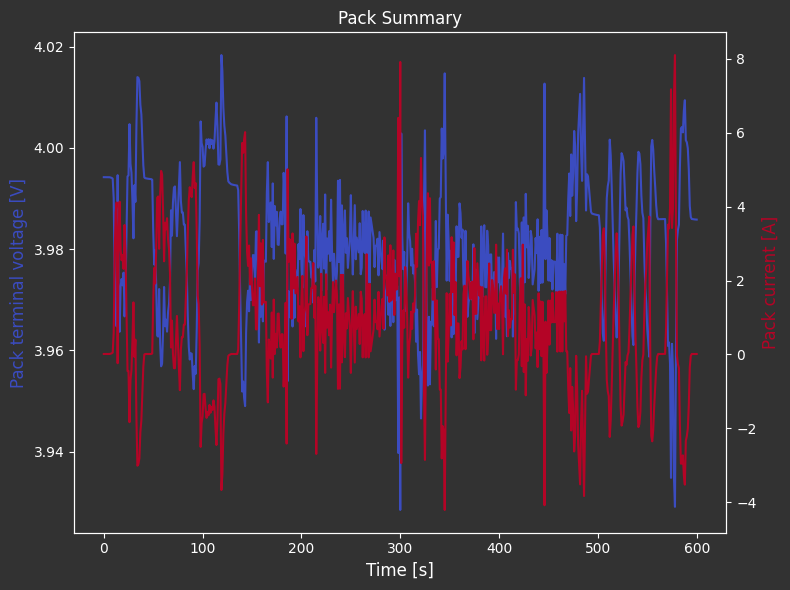

In [9]:
lp.plot_pack(output_d)
lp.show_plots()

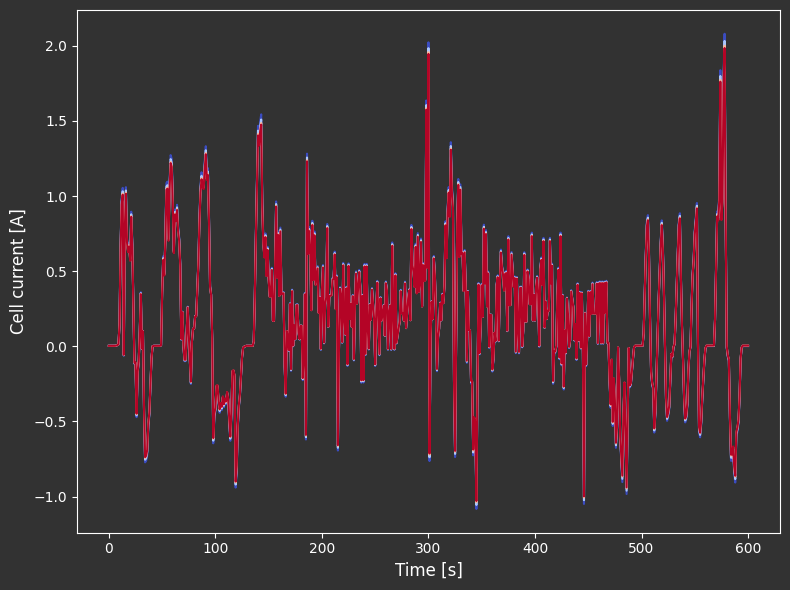

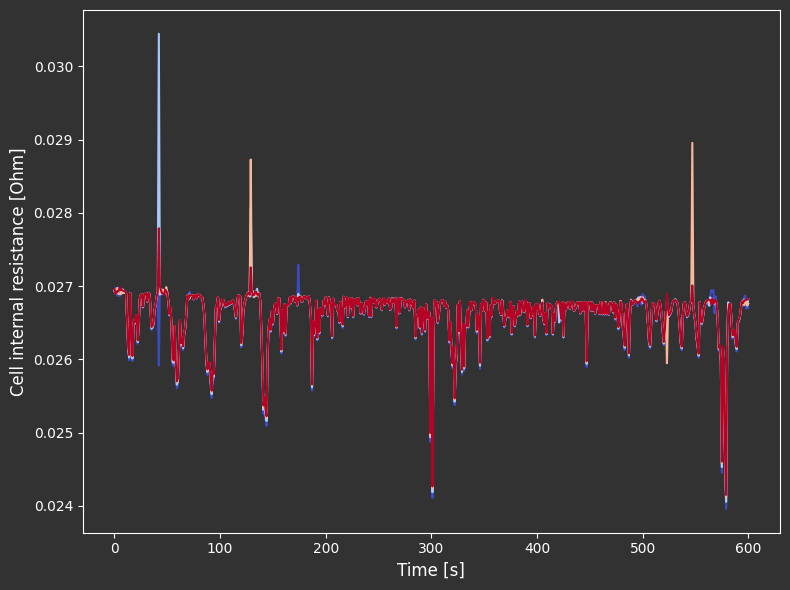

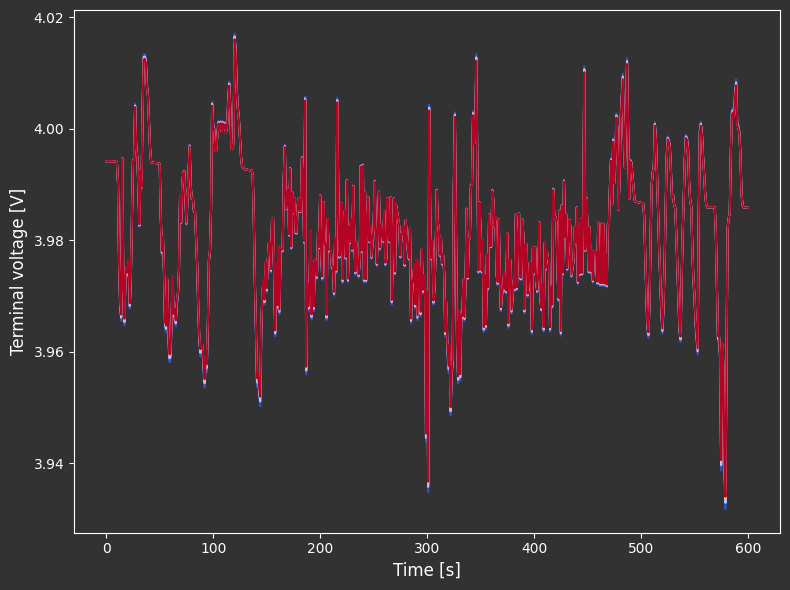

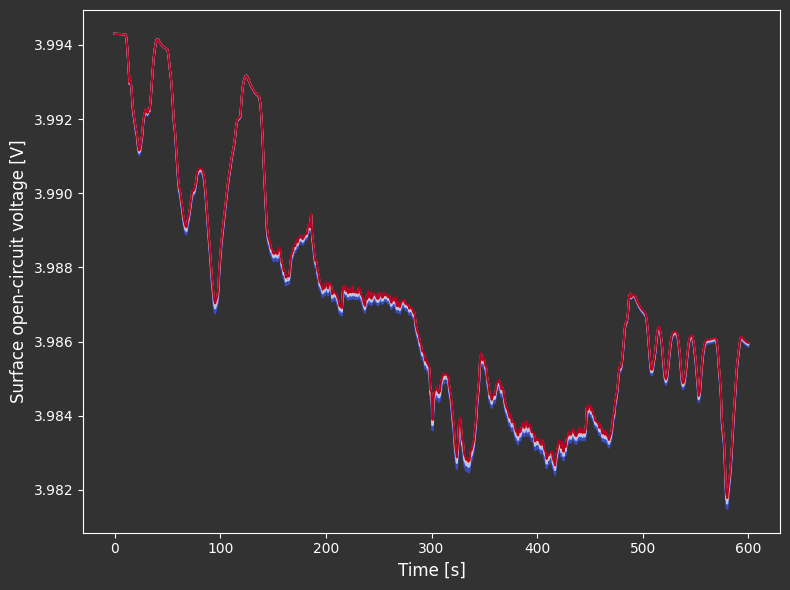

In [10]:
lp.plot_cells(output_d)
lp.show_plots()

The mean current is:

In [11]:
I_mean = np.around(np.mean(drive_cycle[:, 1]), 3)
I_mean

0.84

Let's see what the simulation looks like when we just discharge at the mean current for 600 s.

In [12]:
experiment = pybamm.Experiment(
    [f"Discharge at {I_mean} A for 601 s"], period="1 second"
)

In [13]:
# Solve pack
output_m = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    initial_soc=0.75,
)

Stepping simulation: 100%|██████████████████████████████████████████████████████████| 602/602 [00:05<00:00, 109.56it/s]


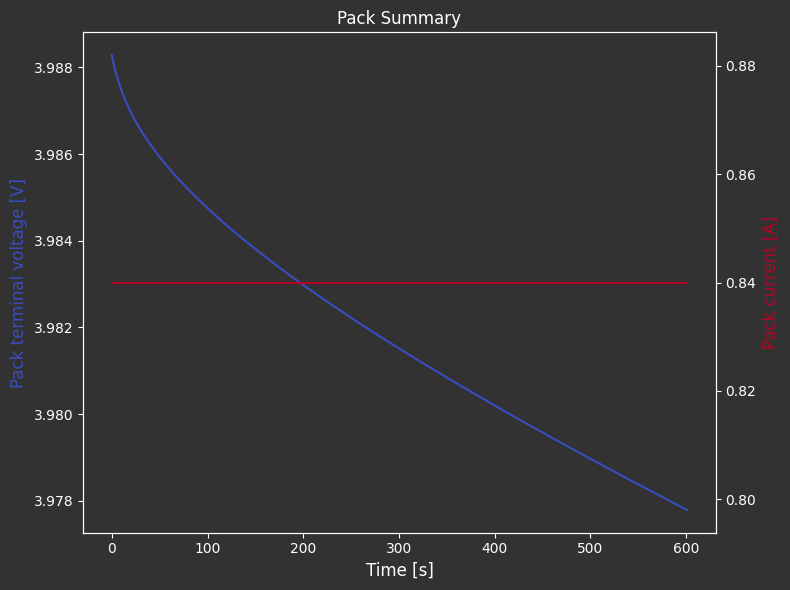

In [14]:
lp.plot_pack(output_m)
plt.show()

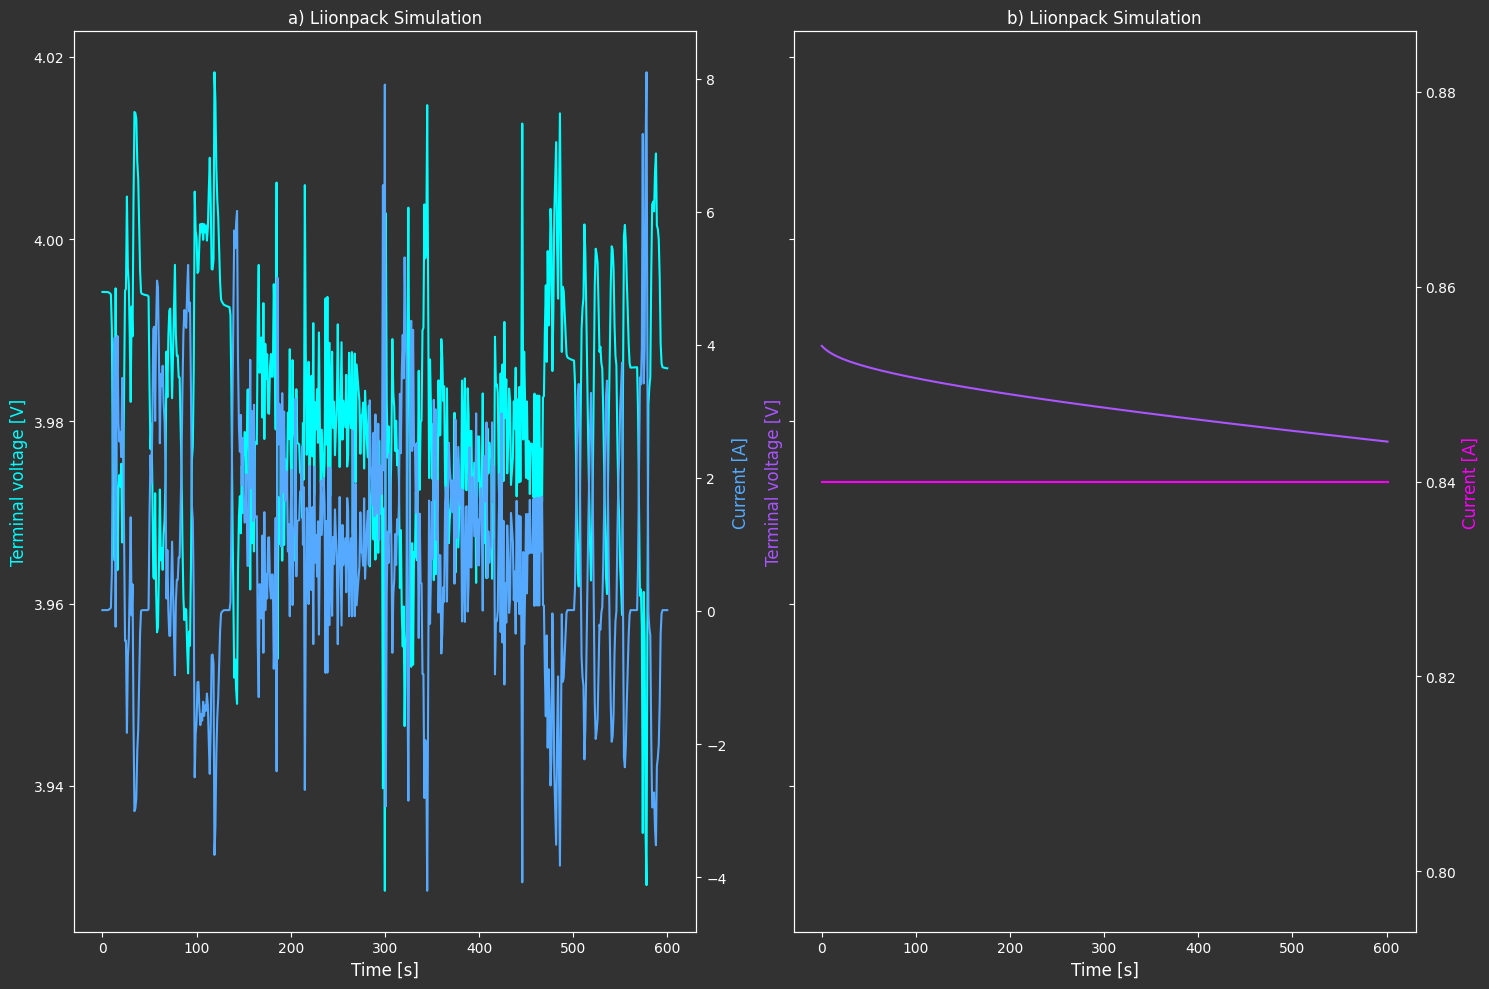

In [15]:
lp.compare_solution_output(output_d, output_m)
plt.show()

Let's see what happens when we change the period to 10 seconds

In [16]:
experiment = pybamm.Experiment(
    [pybamm.step.current(drive_cycle)],
    period="10 seconds",
)

In [17]:
# Solve pack
output_t = lp.solve(
    netlist=netlist,
    parameter_values=parameter_values,
    experiment=experiment,
    initial_soc=0.75,
)

Stepping simulation: 100%|██████████████████████████████████████████████████████████| 601/601 [00:05<00:00, 104.06it/s]


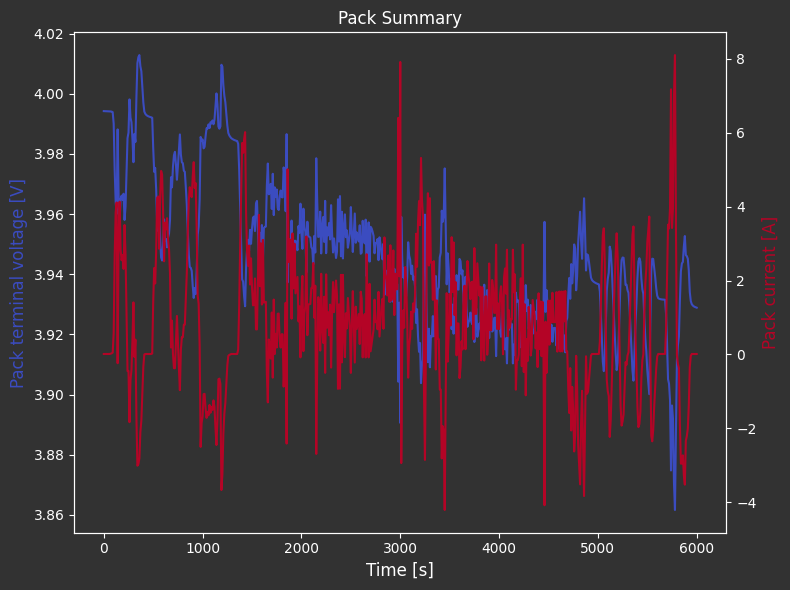

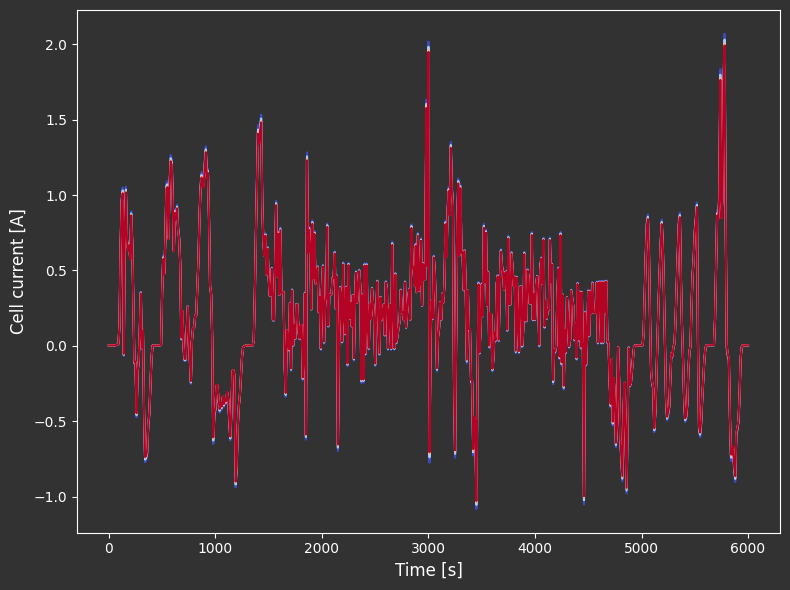

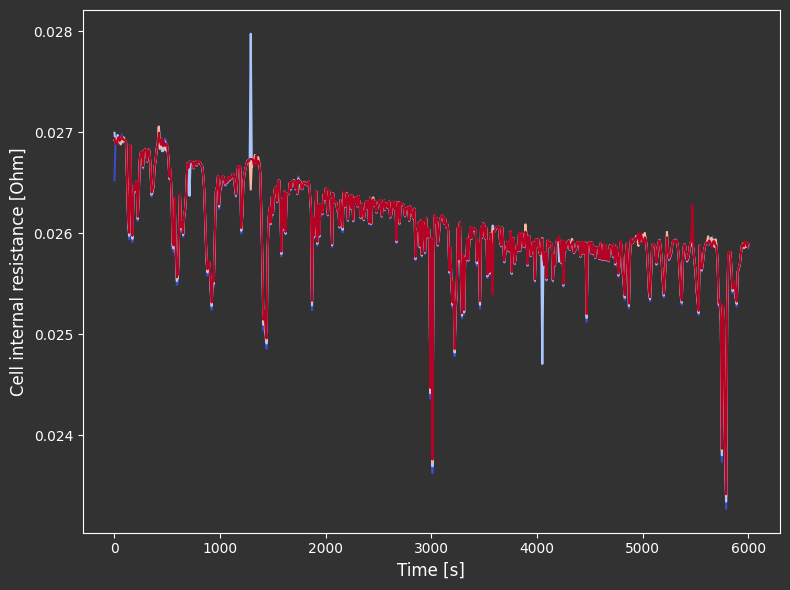

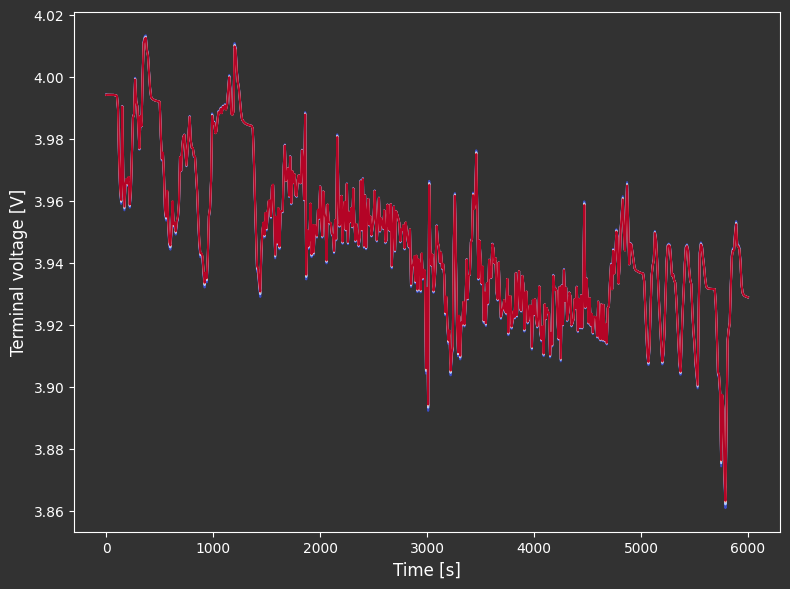

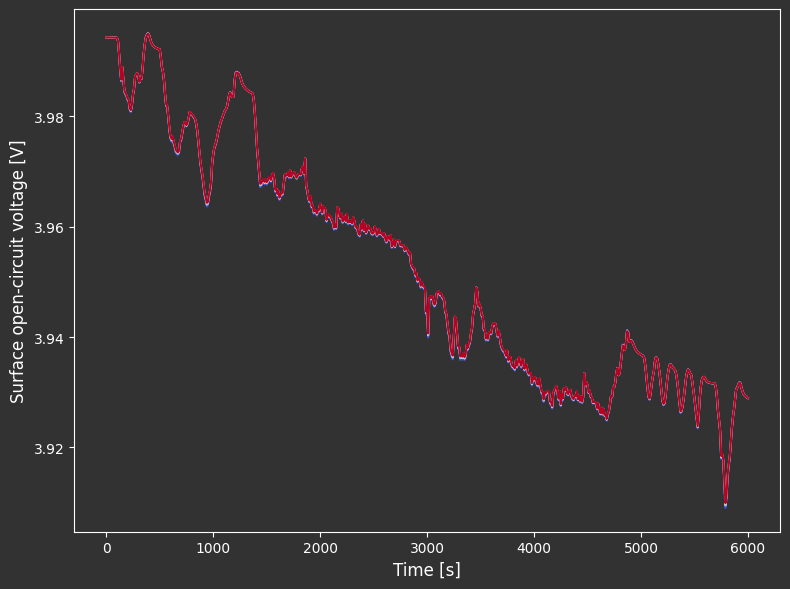

In [18]:
lp.plot_output(output_t)
plt.show()

The drive cycle units in time are modified by the experiment period